In [1]:
#import all the required libraries 

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load the training dataset

df = pd.read_csv('/Users/priya/Downloads/train.csv')

In [3]:
#check the first 5 rows of the train dataset

df.head()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [4]:
#check the value counts of the target variable to examine for class imbalance

print(df['TARGET_5Yrs'].value_counts())

1    6669
0    1331
Name: TARGET_5Yrs, dtype: int64


In [5]:
#drop Id columns as these are insignificant for our predictions

df.drop('Id_old', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

#check the last 5 rows of the train dataset
df.tail()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
7995,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1
7999,49,19.2,4.8,1.7,5.1,32.6,0.7,2.4,41.3,0.8,1.3,70.1,0.1,1.1,1.2,3.5,0.9,-0.3,1.4,1


In [6]:
#remove any trailing characters

df.columns = df.columns.str.strip()
df

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [7]:
#understand the structure of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GP           8000 non-null   int64  
 1   MIN          8000 non-null   float64
 2   PTS          8000 non-null   float64
 3   FGM          8000 non-null   float64
 4   FGA          8000 non-null   float64
 5   FG%          8000 non-null   float64
 6   3P Made      8000 non-null   float64
 7   3PA          8000 non-null   float64
 8   3P%          8000 non-null   float64
 9   FTM          8000 non-null   float64
 10  FTA          8000 non-null   float64
 11  FT%          8000 non-null   float64
 12  OREB         8000 non-null   float64
 13  DREB         8000 non-null   float64
 14  REB          8000 non-null   float64
 15  AST          8000 non-null   float64
 16  STL          8000 non-null   float64
 17  BLK          8000 non-null   float64
 18  TOV          8000 non-null   float64
 19  TARGET

In [8]:
#check the data description and distribution

print(df.describe())

                GP          MIN          PTS          FGM          FGA  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean     62.777875    18.576663     7.267087     2.807037     6.231213   
std      17.118774     8.935263     4.318732     1.693373     3.584559   
min      -8.000000     2.900000     0.800000     0.300000     0.800000   
25%      51.000000    12.000000     4.100000     1.600000     3.600000   
50%      63.000000    16.800000     6.300000     2.400000     5.400000   
75%      74.000000    23.500000     9.500000     3.700000     8.100000   
max     123.000000    73.800000    34.200000    13.100000    28.900000   

               FG%      3P Made          3PA          3P%          FTM  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean     44.608900     0.264525     0.816563    19.583700     1.392525   
std       6.155453     0.384093     1.060964    16.003155     0.926153   
min      21.300000    -1.100000    -3

In [9]:
#check for NULL values

df.isnull().sum()

GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
dtype: int64

In [10]:
#check for duplicates

duplicate = df.duplicated()
print(duplicate.sum())

0


In [11]:
#new variable - 'assists' to 'turnover' ratio

#df['ATR'] = df['AST']/df['TOV']

In [12]:
df

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


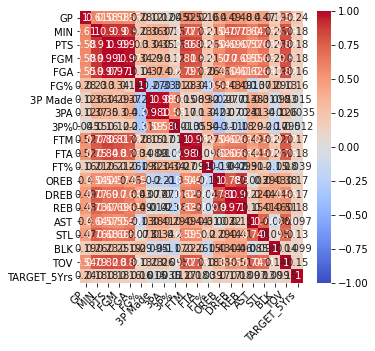

In [13]:
#correlation plot to understand how the variables are correlated

corr = df.corr()
plt.figure(figsize=(5,5))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [14]:
#new variable - Free throw rate 

df['FTR'] = df['FTA'] / df['FGA']

In [15]:
#new variable - turnover percentage 

#df['TOV%'] = 100 * df['TOV'] / (df['FGA'] + 0.44 * df['FTA'] + df['TOV'])

In [16]:
df

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,FTR
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,...,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1,0.453125
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,...,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1,0.455696
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,...,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1,0.133333
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,...,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1,0.223881
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,...,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1,0.147059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,...,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1,0.333333
7996,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,...,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1,0.285714
7997,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,...,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1,0.433333
7998,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,...,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1,0.304348


In [17]:
#check the correlation of new variables with the target variable 

df[df.columns[1:]].corr()['TARGET_5Yrs'][:]

MIN            0.182203
PTS            0.182004
FGM            0.183568
FGA            0.162389
FG%            0.158858
3P Made        0.015016
3PA            0.003463
3P%           -0.011977
FTM            0.173913
FTA            0.176525
FT%            0.039429
OREB           0.172604
DREB           0.168065
REB            0.175627
AST            0.096771
STL            0.128381
BLK            0.098642
TOV            0.151240
TARGET_5Yrs    1.000000
FTR            0.075468
Name: TARGET_5Yrs, dtype: float64

In [18]:
#not considered for modelling as excluding these variables resulted in poor model performance 

#df_cleaned = df.drop(['3PA', '3P%', 'FT%', 'ATR', 'TOV%'], axis = 1)

In [19]:
#assign target variable to a new variable and remove from the main dataset

target = df.pop('TARGET_5Yrs')

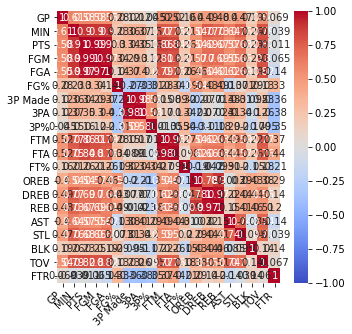

In [20]:
#correlation plot

corr = df.corr()
plt.figure(figsize=(5,5))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [21]:
#split the dataset into train and validation datasets and assign them to new variables

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=8, stratify = target)

In [22]:
#use Xgboostclassifier model as a base model 

xgboost1 = xgb.XGBClassifier()

In [23]:
#fit the model to the train dataset

xgboost1.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
#assign the predicted results to new variables 

y_train_preds = xgboost1.predict(X_train)
y_val_preds = xgboost1.predict(X_test)

In [43]:
#get a classification report to check for accuracy, precision, F1 and recall 

from sklearn.metrics import classification_report
print(classification_report(y_test, y_val_preds))

              precision    recall  f1-score   support

           0       0.37      0.08      0.14       266
           1       0.84      0.97      0.90      1334

    accuracy                           0.82      1600
   macro avg       0.61      0.53      0.52      1600
weighted avg       0.76      0.82      0.77      1600



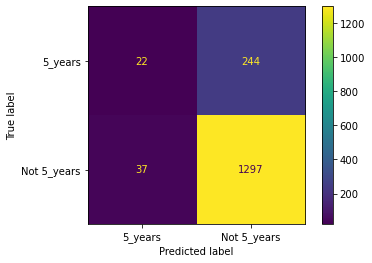

In [25]:
#plot confusion matrix to check for True/False positives/negatives. 

plot_confusion_matrix(xgboost1,X_test,y_test,values_format='d', display_labels=["5_years", "Not 5_years"])

In [26]:
#accuracy score

xgboost1.score(X_test, y_test)

0.824375

In [27]:
#predict probability for validation dataset

xgboost1.predict_proba(X_test)

array([[0.10147423, 0.8985258 ],
       [0.0867452 , 0.9132548 ],
       [0.02883476, 0.97116524],
       ...,
       [0.00485647, 0.99514353],
       [0.08066672, 0.9193333 ],
       [0.45734704, 0.54265296]], dtype=float32)

In [28]:
#get the auroc score

roc=roc_auc_score(y_test, xgboost1.predict_proba(X_test)[:,1])
roc

0.633030289366595

In [29]:
#hyperparameter tuning using hyperopt 

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

In [30]:
#specify the different ranges

space = {
    'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05)
}

In [31]:
#define the objective 

def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree']
    )
    
    acc = cross_val_score(xgboost, X_train, y_train, cv=10, scoring="accuracy").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }

In [32]:
#provide the specifics to the best parameters

best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)

[19:23:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[19:23:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[19:23:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[19:24:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[19:24:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[19:24:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

In [33]:
#print the best parameters

print("Best: ", best)

Best:  {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3.0, 'subsample': 0.9}


In [34]:
#train the model using the best parameters obtained after hyperparameter tuning

xgboost2 = xgb.XGBClassifier(
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree']
)

In [35]:
#fit the model to the train dataset

xgboost2.fit(X_train, y_train)

[19:24:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

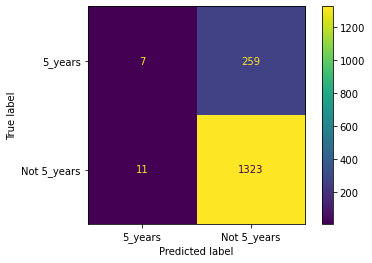

In [36]:
#plot confusion matrix : True positives/negatives, False positives/negatives

plot_confusion_matrix(xgboost2,X_test,y_test,values_format='d', display_labels=["5_years", "Not 5_years"])

In [37]:
#predict for validation dataset 

y_pred = xgboost2.predict(X_test)

In [44]:
#get the classification report to get a score for accuracy, precision, F1 and recall

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.03      0.05       266
           1       0.84      0.99      0.91      1334

    accuracy                           0.83      1600
   macro avg       0.61      0.51      0.48      1600
weighted avg       0.76      0.83      0.76      1600



In [38]:
#accuracy score after hyperparameter tuning 

xgboost2.score(X_test, y_test)

0.83125

In [39]:
#auroc score after hyperparameter tuning 

roc=roc_auc_score(y_test, xgboost2.predict_proba(X_test)[:,1])
roc

0.6782811601717937

In [40]:
#load the test dataset and drop the ID columns 

df1 = pd.read_csv('/Users/priya/Downloads/test.csv')
df1.drop('Id', axis=1, inplace=True)
df1.drop('Id_old', axis=1, inplace=True)

In [41]:
#predict probabilities for 1's

final = xgboost2.predict_proba(df1)[:,1]

In [42]:
#download the probability scores as a csv file.. 

pd.DataFrame(final).to_csv("/Users/priya/Downloads/xgb2.csv")